# <a id='toc1_'></a>[sGB ADM C code generation and simulation](#toc0_)
This notebook generates C codes for the simulation of sGB ADM gravity, performs the simulation and gives graphs of results. More explanation on the NRPy+ modules and how they work is provided in the Appendix A of the thesis. 


**Table of contents**<a id='toc0_'></a>    
- [sGB ADM C code generation and simulation](#toc1_)    
  - [Generation of C code for sGB ADM simulation](#toc1_1_)    
    - [Import modules and set up fundamental parameters for generation](#toc1_1_1_)    
    - [Create MOL timestepping code](#toc1_1_2_)    
    - [Set the parameters to NRPy+ modules](#toc1_1_3_)    
    - [Generate code for setting up initial data](#toc1_1_4_)    
    - [Generate rfm files and timestep](#toc1_1_5_)    
    - [Generate code for RHS evaluation](#toc1_1_6_)    
      - [Set up sGB ADM quantitites and calculate RHS for the equations](#toc1_1_6_1_)    
      - [Register gridfunctions and parameters](#toc1_1_6_2_)    
      - [Generate C function for RHS evaluation](#toc1_1_6_3_)    
      - [Generate code for the Hamiltonian constraint evaluation](#toc1_1_6_4_)    
      - [Create file with function definitions calculating finite differences](#toc1_1_6_5_)    
    - [Set C parameters](#toc1_1_7_)    
    - [Generate boundary conditions](#toc1_1_8_)    
    - [Generate C code for rescaled -> unrescaled calculation](#toc1_1_9_)    
    - [Main C code](#toc1_1_10_)    
  - [Run the simulation](#toc1_2_)    
  - [Results](#toc1_3_)    
      - [Interpolate and compare $\mathcal{H}$ multiplied by the truncation error](#toc1_3_1_1_)    
      - [Interpolate and subtract $\mathcal{H}$ scaled to the same trunction error for increasing resolutions](#toc1_3_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Generation of C code for sGB ADM simulation](#toc0_)
### <a id='toc1_1_1_'></a>[Import modules and set up fundamental parameters for generation](#toc0_)

In [ ]:
import shutil, os, sys
import sympy as sp
sys.path.append('nrpy') # Adding NRPy's root directory to the path.
sys.path.append(os.path.join('nrpy','CurviBoundaryConditions'))

# Import needed NRPy+ modules:
from outputC import outputC,lhrh,outCfunction,outC_function_dict,add_to_Cfunction_dict # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Module for generating finite differences
import NRPy_param_funcs as par   # NRPy+: Module for handling of parameters
import grid as gri               # NRPy+: Grid and gridfunction creation
import reference_metric as rfm   # NRPy+: Module for handling reference (flat) metric and related expressions
import cmdline_helper as cmd     # NRPy+: Command-line interface for compilation and execution of C code
import indexedexp as ixp         # NRPy+: Module for creation of tensorial expressions based on SymPy

# Import file containing function for setting up th sGB ADM equations.
import sGB_ADM_quantities as sGB


# Choose a directory for generated C codes.
Ccodesdir = os.path.join("sGB_ADM_Ccodes/")

# First remove C code directory if it exists.
shutil.rmtree(Ccodesdir, ignore_errors=True)
cmd.mkdir(Ccodesdir)

# Create a directory for the executable file and its output.
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

# Set the dimension. NRPy+ assumes default dimension 3. 
par.set_parval_from_str("grid::DIM",3)

# Store the dimension in the DIM variable.
DIM = par.parval_from_str("grid::DIM")

indices = [(0,0), (1,1), (2,2)] # Indices will run trough diagonal components of tensors \gamma_{ij} and A_{ij} due to spherical symmetry.

# Disable Single Instruction Multiple Data (SIMD).
enable_SIMD = False

# Choose the cordinate system and default values for the parameters of the chosen coordinates.
# CoordSystem   = "Spherical"
CoordSystem     = "SinhSpherical"
# sinh_width      = 0.07  # Width of the sinh argument in SinhSpherical coordinates
sinh_width  = 0.1

# Spatial domain size
domain_size     = 1000

RK_method = "RK4"       # RK method is set to Runge--Kutta of 4th order.
FD_order  = 4           # Finnite difference order is chosen.
REAL      = "double"    # Floating point accuracy.
default_CFL_FACTOR = 0.5 # Default CFL factor is chosen. (Overwritten at execution.)

### <a id='toc1_1_2_'></a>[Create MOL timestepping code](#toc0_)
- Choose RK algorithm from the Butcher_dict.
- Make a directory where the MOL timestepping C code will be saved.
- Generate the C code.

In [ ]:
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict

RK_order  = Butcher_dict[RK_method][1] # Chooses RK4 as the RK method.
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))

MoL.MoL_C_Code_Generation(RK_method,
    RHS_string      = """
rhs_eval(xx, &params, RK_INPUT_GFS, RK_OUTPUT_GFS);""",
    post_RHS_string = """
apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_OUTPUT_GFS);""",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

### <a id='toc1_1_3_'></a>[Set the parameters to NRPy+ modules](#toc0_)

In [ ]:
# Set the Coordinate system.
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric() # Reference metric and related Rescaling quantities are generated by this call.

# Set the finnite differencing order and enable functions for FD. 
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)
enable_FD_functions = True
par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# For enabled SIMD, file, code containing SIMD definitions is copied to Ccodesdir\SIMD file. 
# For disabed SIMD information for this choice is saved instead.
cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
if enable_SIMD == True:
    shutil.copy(os.path.join("SIMD","SIMD_intrinsics.h"),os.path.join(Ccodesdir,"SIMD/"))
else:
    with open(os.path.join(Ccodesdir,"SIMD","SIMD_intrinsics.h"), "w") as file:
        file.write("#define SIMD_IS_DISABLED\n")

# Set the symmetry of the problem. For spherically symmetric problem this means we need to set the symmetry axes as
# 1 and 2, which corresponds to \theta and \phi respectively.
par.set_parval_from_str("indexedexp::symmetry_axes","12")

### <a id='toc1_1_4_'></a>[Generate code for setting up initial data](#toc0_)

To get the initial data in a proper form they are setup using a modified code from NRPy+ code from BSSN\ADM_Exact_Spherical_or_Cartesian_to_BSSNCurvilinear.py. The initial data are
 - Loaded as functions in spherical coordinates.
 - Transformed to the coordinate system chosen for the simulation.
 - The tensors are rescaled.
 - C code for the assignment is generated.

In [ ]:
# Step 1 and 2: The initial data is created and loaded inside our sGB module.
sGB.setup_sGB_ADM_quantities(get_data_from='ID')

gammaDD = sGB.gammaDD
ADD     = sGB.ADD
Ktr     = sGB.Ktr
betaU   = sGB.betaU
Phi     = sGB.Phi
KPhi    = sGB.KPhi
alpha   = sGB.alpha

# Step 3: Rescaled quantities are defined from the unrescaled quantities containing ID.
hDD = ixp.zerorank2()

gammaUU, gammaDET = ixp.symm_matrix_inverter3x3(gammaDD) # _gammaUU unused.

for i in range(DIM):
    for j in range(DIM):
        hDD[i][j] = (gammaDD[i][j] - rfm.ghatDD[i][j]) / rfm.ReDD[i][j]

aDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        aDD[i][j] = ADD[i][j] / rfm.ReDD[i][j]

vetU = ixp.zerorank1()
for i in range(DIM):
    vetU[i] = betaU[i]/rfm.ReU[i]

In [ ]:
# Step 4: Generate code for assignment.

# The `includes` parameter is used to include the necessary header files.
includes = []

# The `rhss` contain right-hand sides (expressions), `lhss` specify where to store the results of the evaluation
rhss = [Phi, Ktr, alpha, KPhi]
lhss = ["in_gfs[IDX4S(PHIGF,i0,i1,i2)]","in_gfs[IDX4S(KTRGF,i0,i1,i2)]","in_gfs[IDX4S(ALPHAGF,i0,i1,i2)]","in_gfs[IDX4S(KPHIGF,i0,i1,i2)]"]
for i in range(3):
    rhss.append(vetU[i])
    lhss.append("in_gfs[IDX4S(VETU"+str(i)+"GF,i0,i1,i2)]")
    for j in range(i,3):
        rhss.append(hDD[i][j])
        lhss.append("in_gfs[IDX4S(HDD" + str(i) + str(j) + "GF,i0,i1,i2)]")
        rhss.append(aDD[i][j])
        lhss.append("in_gfs[IDX4S(ADD" + str(i) + str(j) + "GF,i0,i1,i2)]")

# The lhss and rhss lists are sorted in the same order.
lhss,rhss = [list(x) for x in zip(*sorted(zip(lhss, rhss), key=lambda pair: pair[0]))]

# The `body` of the loop that will go through all points in the (spatial) numerical grid.
body = outputC(rhss, lhss, filename="returnstring",
                params="preindent=1,CSE_enable=True,outCverbose=False",    # outCverbose=False prevents outputing the original
                prestring="", poststring="")                               # SymPy expressions in the C code a comment. 

desc = "Set up the initial data at all points on the numerical grid."

# Generate the loop and add to a dict, then output to a file.
add_to_Cfunction_dict(
    includes=includes,
    desc    =desc,
    name    ="initial_data",
    params  ="const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs",
    body    =body,
    loopopts="AllPoints,Read_xxs") # For analytic data all points can be looped, Read xxs reads gridpoint 

with open(os.path.join(Ccodesdir, "initial_data.h"), "w") as file:
    file.write(outC_function_dict['initial_data'])

### <a id='toc1_1_5_'></a>[Generate rfm files and timestep](#toc0_)
- The rfm_precompute will be disabled as we are using sGB ADM equations modified for spherical symmetry. In those equations, expressions such as `sin(xx1)` are present outside of the rfm_precompute quantities such as the `ghatDD` metric. This causes the NRPy+ not to work for our case. (Enabled rfm_precompute precalculates expressions present in the flat metric and rescaling parameters at each point before evaluation of the loops, so expressions like `sin(xx1)` are evaluated only once for each spatial point.)

In [ ]:
# Output the find_timestep() function to a C file.
rfm.out_timestep_func_to_file(os.path.join(Ccodesdir,"find_timestep.h"))

cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

# rfm.reference_metric()

### <a id='toc1_1_6_'></a>[Generate code for RHS evaluation](#toc0_)
#### <a id='toc1_1_6_1_'></a>[Set up sGB ADM quantitites and calculate RHS for the equations](#toc0_)
The coupling function needs to be chosen here.

In [ ]:
# Choose coupling function f(\Phi)
Phi = sp.Symbol('Phi')
# f = sp.Rational(1,12)*(1-sp.exp(-2*Phi))
f = sp.Rational(1,2)*Phi**2

# Set f inside the sGB module
sGB.set_f(f)

# Setup sGB quantities and calculate the right-hand sides of the sGB ADM equations.
sGB.setup_sGB_ADM_quantities()
sGB.calculate_rhs()

#### <a id='toc1_1_6_2_'></a>[Register gridfunctions and parameters](#toc0_)

In [ ]:
Phi, KPhi, Ktr, alpha = gri.register_gridfunctions("EVOL",["Phi", "KPhi", "Ktr", "alpha"])
hDD = ixp.register_gridfunctions_for_single_rank2("EVOL", "hDD", "sym01")
aDD = ixp.register_gridfunctions_for_single_rank2("EVOL", "aDD", "sym01")
vetU = ixp.register_gridfunctions_for_single_rank1("EVOL","vetU")


thismodule = "sGB_ADM"
alphaGB = par.Cparameters("REAL", names = ["alphaGB"], module = thismodule,default_vals = 0)    # The sGB coupling constant
M = par.Cparameters("REAL", names = ["M"], module = thismodule,default_vals = 1.0)              # Mass of the BH for initial data


Hconstr = gri.register_gridfunctions("AUX","Hconstr")   # Hamiltonian constraint

#### <a id='toc1_1_6_3_'></a>[Generate C function for RHS evaluation](#toc0_)
Similiar procedure as for the case of inital data is done, except the evol. equations are used instead.

In [ ]:
lhs_names = ['Phi', 'KPhi', 'Ktr', 'alpha']
rhs_expressions = [sGB.Phi_rhs, sGB.KPhi_rhs, sGB.Ktr_rhs, sGB.alpha_rhs]
for i in range(DIM):
    lhs_names.append('vetU'+str(i))
    rhs_expressions.append(sGB.vetU_rhs[i])
    for j in range(i, DIM):
        lhs_names.append('hDD'+str(i)+str(j))
        rhs_expressions.append(sGB.hDD_rhs[i][j])
        lhs_names.append('aDD'+str(i)+str(j))
        rhs_expressions.append(sGB.aDD_rhs[i][j])

# Order the expressions alphabetically.
sorted_dict = dict(sorted({key:value for key,value in zip(lhs_names,rhs_expressions)}.items()))
lhs_names = list(sorted_dict.keys())
rhs_expressions = list(sorted_dict.values())

# lhrh is a macro for the FD_outputC function.
lhrh_list = []
for var in range(len(lhs_names)):
    lhrh_list.append(lhrh(lhs = gri.gfaccess("rhs_gfs", lhs_names[var]), rhs = rhs_expressions[var]))

outCparams = "outCverbose=False,CSE_enable=True"
loopopts = "InteriorPoints,Read_xxs"
if enable_SIMD:
    loopopts += ",enable_SIMD"
    outCparams += ",enable_SIMD=True"

includes = None
if enable_FD_functions:
    includes = ["finite_difference_functions.h"]

desc = "Evaluate the sGB ADM RHSs"
name = "rhs_eval"
outfile = os.path.join(Ccodesdir,name+".h")
params = """REAL *restrict xx[3], const paramstruct *restrict params, const REAL *restrict in_gfs, REAL *restrict rhs_gfs"""
body = fin.FD_outputC("returnstring", lhrh_list, params = outCparams, upwindcontrolvec=betaU)

outCfunction(outfile = outfile, includes = includes, desc = desc, name = name,
                params = params, body = body, loopopts = loopopts)

Output C function rhs_eval() to file sGB_ADM_Ccodes/rhs_eval.h


#### <a id='toc1_1_6_4_'></a>[Generate code for the Hamiltonian constraint evaluation](#toc0_)

In [ ]:
H = sGB.H

includes = None
if enable_FD_functions:
    includes = ["finite_difference_functions.h"]
desc="Evaluate the Hamiltonian constraint"
name="H_eval"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), includes=includes, desc=desc, name=name,
    params   = """REAL *restrict xx[3],const paramstruct *restrict params,
                      REAL *restrict in_gfs, REAL *restrict aux_gfs""",
    body     = fin.FD_outputC("returnstring", lhrh(lhs = gri.gfaccess("aux_gfs","Hconstr"), rhs = H), params = "outCverbose=False"),
    loopopts = "InteriorPoints,Read_xxs")

Output C function H_eval() to file sGB_ADM_Ccodes/H_eval.h


#### <a id='toc1_1_6_5_'></a>[Create file with function definitions calculating finite differences](#toc0_)
We have used `enable_FD_functions = True`, which causes the `outputC` function to use predefined function FD calculation. Following call generates the FD functions.

In [ ]:
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesdir)

### <a id='toc1_1_7_'></a>[Set C parameters](#toc0_)

In [ ]:
with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write("""
// Set free parameters for the sGB ADM evolution.
params.alphaGB = 0.0;
params.M  = 1;\n""")
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width)
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir)
rfm.xx_to_Cart_h("xx_to_Cart","./set_Cparameters.h",os.path.join(Ccodesdir,"xx_to_Cart.h"))
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

In [ ]:
with open(os.path.join(Ccodesdir,"sGB_ADM_REAL__NGHOSTS__CFL_FACTOR.h"), "w") as file:
    file.write("""
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
#define REAL """+REAL+"""
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+";")

### <a id='toc1_1_8_'></a>[Generate boundary conditions](#toc0_)

In [ ]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),Cparamspath=os.path.join("../"), path_prefix='nrpy/')

Wrote to file "sGB_ADM_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( KPhi:0, Ktr:0, Phi:0, aDD00:4, aDD01:5, aDD02:6, aDD11:7,
    aDD12:8, aDD22:9, alpha:0, hDD00:4, hDD01:5, hDD02:6, hDD11:7, hDD12:8,
    hDD22:9, vetU0:1, vetU1:2, vetU2:3 )
Auxiliary parity: ( Hconstr:0 )

Wrote to file "sGB_ADM_Ccodes/boundary_conditions/EigenCoord_Cart_to_xx.h"


### <a id='toc1_1_9_'></a>[Generate C code for rescaled -> unrescaled calculation](#toc0_)

In [ ]:
gammaDD = ixp.zerorank2()
ADD = ixp.zerorank2()
# betaU = ixp.zerorank1()

hDD = ixp.declarerank2("hDD", symmetry = "sym01")
aDD = ixp.declarerank2("aDD", symmetry = "sym01")
# vetU = ixp.declarerank1("vetU")

for i in range(DIM):
    betaU[i] += vetU[i]*rfm.ReU[i]
    for j in range(DIM):
        gammaDD[i][j]+= hDD[i][j]*rfm.ReDD[i][j] + rfm.ghatDD[i][j]
        ADD[i][j] += aDD[i][j]*rfm.ReDD[i][j]

r_th_ph_of_xx = rfm.xxSph
Jac_dUSph_dDrfmUD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        Jac_dUSph_dDrfmUD[i][j] = sp.diff(r_th_ph_of_xx[i],rfm.xx[j])

Jac_dUrfm_dDSphUD, dummyDET = ixp.generic_matrix_inverter3x3(Jac_dUSph_dDrfmUD)

gammaDD_sph = ixp.zerorank2()
ADD_sph = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
            for l in range(DIM):
                gammaDD_sph[i][j] += Jac_dUrfm_dDSphUD[k][i]*Jac_dUrfm_dDSphUD[l][j] * gammaDD[k][l]
                ADD_sph[i][j]     += Jac_dUrfm_dDSphUD[k][i]*Jac_dUrfm_dDSphUD[l][j] *     ADD[k][l]
# gammaDD_sph = gammaDD
# ADD_sph = ADD

sGB_to_ADM_string =[]
for i in range(len(indices)):
    row, col = indices[i]
    sGB_to_ADM_string.append(lhrh(lhs= gri.gfaccess("rhs_gfs",f"hDD{row}{col}"), rhs = gammaDD_sph[row][col]))

for i in range(len(indices)):
    row, col = indices[i]
    sGB_to_ADM_string.append(lhrh(lhs= gri.gfaccess("rhs_gfs",f"aDD{row}{col}"), rhs = ADD_sph[row][col]))

In [ ]:
includes = None
desc="find unrescaled ADM quantities where necessary"
name="sGBADM_to_ADM"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), includes=includes, desc=desc, name=name,
    params   = """REAL *restrict xx[3],const paramstruct *restrict params,const REAL *restrict in_gfs,REAL *restrict rhs_gfs""",
    body     = fin.FD_outputC("returnstring", sGB_to_ADM_string),
    loopopts = "InteriorPoints, Read_xxs")

Output C function sGBADM_to_ADM() to file sGB_ADM_Ccodes/sGBADM_to_ADM.h


### <a id='toc1_1_10_'></a>[Main C code](#toc0_)
The reason for writting C code in Jupyter is just for convenience (changing parameters, debugging errors in the _generated_ C code etc.). To read the code just run the cell and look at `sGB_ADM_Ccodes/sGB_ADM.c`.

In [ ]:
%%writefile $Ccodesdir/sGB_ADM.c

#include "sGB_ADM_REAL__NGHOSTS__CFL_FACTOR.h"


#include "declare_Cparameters_struct.h"

#include "SIMD/SIMD_intrinsics.h"
#ifdef SIMD_IS_DISABLED
#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0
#endif

#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h"
#include <string.h>

// Constants are defined.
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif

#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

#define wavespeed 1.0 // CFL wavespeed set to 1.0

// Indexing macros for accesing the gridfunctions and a gridpoint and looping the gridfunctions.
#define IDX4S(g,i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Generated files are included.
#include "boundary_conditions/gridfunction_defines.h"
#include "xx_to_Cart.h"
#include "set_Nxx_dxx_invdx_params__and__xx.h"
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

#include "find_timestep.h"
#include "initial_data.h"

int time_step;

#include "rhs_eval.h"
#include "sGBADM_to_ADM.h"
#include "H_eval.h"



int main(int argc, const char *argv[]) {
    if (argc < 4) {
        fprintf(stderr, 
            "Error: Expected 3 to 6 command line arguments, %d were given.\n"
            "The command-line arguments are:\n"
            "   1, 2, 3           : (int) N_r, N_th, N_phi - number of gridpoints in each coordinate direction\n"
            "   4 (optional)      : (double) CFL factor\n"
            "   5 (optional)      : (double) alpha_GB coupling constant value \n", 
            argc - 1);
        return 1;
    }
	// Save first 3 arguments (gridsizes) to Nxx[] array
	if(argc > 4) CFL_FACTOR = strtod(argv[4], NULL);
	const int Nxx[3] = {atoi(argv[1]), atoi(argv[2]), atoi(argv[3])};

	// Initialize params struct and set the parameters.
	paramstruct params;
	#include "set_Cparameters_default.h"
	#include "free_parameters.h"
	if(argc == 6) params.alphaGB = strtod(argv[5], NULL);

	// The xx[] array stores the gridpoints
	REAL *xx[3];
	// The following code sets up the boundary condition mappings. 
	bc_struct bcstruct;
	{
		int EigenCoord = 1;
		set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
		#include "set_Cparameters-nopointer.h"
		const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
		#include "boundary_conditions/driver_bcstruct.h"
		for(int i=0; i<3; i++) free(xx[i]);
	}

	int EigenCoord = 0;
	set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

	#include "set_Cparameters-nopointer.h"
	// Calculate sum of all gridpoints including ghost zones.
	const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

	const REAL t_final = 5; 				// Final time of the evolution.
	REAL dt = find_timestep(&params, xx);	// CFL-determined timestep.

	// We output the t and dt to a file for evaluation of the results.
	char filename[100]; // Variable for storing filenames in the whole program.
	sprintf(filename, "t_dt_%d.txt", Nxx[0]); 
	FILE *out_tdt = fopen(filename, "w");
	fprintf(out_tdt, "%.15e %.15e\n", t_final, dt);
	fclose(out_tdt);

	// Calculate the number of timesteps.
	int N_final = (int)(t_final / dt + 0.5);
	printf("Number of time steps N_final = %d\n", N_final);

	// Allocate memory for MOL for the gfs arrays used in the MOL timestepping.
	#include "MoLtimestepping/RK_Allocate_Memory.h"

	// Store initial data into y_n_gfs array.
	initial_data(&params, xx, y_n_gfs);

	// Calculate ghost zone points for the initial data
	apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, y_n_gfs);

	// Evaluate H for the first time and then output the .txt file. (Must be done here before the main loop)
	// --------------------------------------------------------------------------------------
	H_eval(xx, &params, y_n_gfs, diagnostic_output_gfs);
	sGBADM_to_ADM(xx, &params, y_n_gfs, diagnostic_output_gfs);

	sprintf(filename, "out%d-%08d.txt", Nxx[0], 0);
	FILE *out2D = fopen(filename, "w");

	LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
				NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
				NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {

		const int idx = IDX3S(i0, i1, i2);
		REAL xx0 = xx[0][i0]; REAL xx1 = xx[1][i1]; REAL xx2 = xx[2][i2];
		REAL xCart[3];
		xx_to_Cart(&params, xx, i0, i1, i2, xCart);
		fprintf(out2D, "%e %e %e %e %e %e %e %e %e %e %e\n", xCart[0],xCart[1],xCart[2],
											log10(fabs(diagnostic_output_gfs[IDX4ptS(HCONSTRGF, idx)])),
											diagnostic_output_gfs[IDX4ptS(HCONSTRGF, idx)],
											y_n_gfs[IDX4ptS(PHIGF, idx)],
											y_n_gfs[IDX4ptS(KTRGF, idx)],
											y_n_gfs[IDX4ptS(KPHIGF, idx)],
											diagnostic_output_gfs[IDX4ptS(HDD00GF, idx)],
											diagnostic_output_gfs[IDX4ptS(HDD11GF, idx)],
											y_n_gfs[IDX4ptS(ADD00GF, idx)]);
	}
	fclose(out2D);
	// -------------------------------------------------------------------------------------
	// Perform the time-stepping.
	for(int n=0; n<=N_final; n++) {
        time_step = n;
		// RK_MoL.h containts the time-stepping loops.
		#include "MoLtimestepping/RK_MoL.h"
		// Save desired indices of files. We save a lot more out*.txt files than necessary for evaluation purposes.
		// For a more decluttered output, change n % 5 -> n % 100 or similar. 
		// --------------------------------------------------------------------------------
		if((n % 5 == 0 || n == N_final) && n != 0) {
            sGBADM_to_ADM(xx, &params, y_n_gfs, diagnostic_output_gfs);
			H_eval(xx, &params, y_n_gfs, diagnostic_output_gfs);

			sprintf(filename, "out%d-%08d.txt", Nxx[0], n);
            if(n == N_final){
			sprintf(filename, "out%d.txt", Nxx[0]);
            }
			FILE *out2D = fopen(filename, "w");

			LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
	                    NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
	                    NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {

				const int idx = IDX3S(i0, i1, i2);
				REAL xx0 = xx[0][i0]; REAL xx1 = xx[1][i1]; REAL xx2 = xx[2][i2];
				REAL xCart[3];
				xx_to_Cart(&params, xx, i0, i1, i2, xCart);
				fprintf(out2D, "%e %e %e %e %e %e %e %e %e %e %e\n", xCart[0],xCart[1],xCart[2],
												   log10(fabs(diagnostic_output_gfs[IDX4ptS(HCONSTRGF, idx)])),
												   diagnostic_output_gfs[IDX4ptS(HCONSTRGF, idx)],
                                                	y_n_gfs[IDX4ptS(PHIGF, idx)],
                                                   y_n_gfs[IDX4ptS(KTRGF, idx)],
                                                   y_n_gfs[IDX4ptS(KPHIGF, idx)],
                                                   diagnostic_output_gfs[IDX4ptS(HDD00GF, idx)],
													diagnostic_output_gfs[IDX4ptS(HDD11GF, idx)],
                                                   y_n_gfs[IDX4ptS(ADD00GF, idx)]);
			}
			fclose(out2D);
			// -------------------------------------------------------------------------------
		}

	}
	// Free memory and terminate program.
	#include "boundary_conditions/bcstruct_freemem.h"
	#include "MoLtimestepping/RK_Free_Memory.h"
	for(int i=0; i<3; i++) free(xx[i]);

	return 0;

}

Writing sGB_ADM_Ccodes//sGB_ADM.c


## <a id='toc1_2_'></a>[Run the simulation](#toc0_)
Here one can choose the `alphaGB` coupling constant and parameters `CFL_FACTOR`, `Nxx0`, `Nxx1`, `Nxx2`. For different coupling function the code should be rerun with a [changed coupling function](#setup-sGB-ADM-quantitites-and-calculate-RHS-for-the-equations). 


In [ ]:
import cmdline_helper as cmd
CFL_FACTOR= 1
alphaGB = 0.05

# Compile the C code
cmd.C_compile(os.path.join(Ccodesdir,"sGB_ADM.c"),
              os.path.join(outdir,"sGB_ADM"),compile_mode="optimized")

# Go to the output directory
outdir = os.path.join("sGB_ADM_Ccodes","output")
os.chdir(outdir)

# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("t_dt_*.txt")

# Choose resolutions and run the executable
r_resolutions = [200, 300, 400] 
for res in r_resolutions:
    cmd.Execute("sGB_ADM",f"{res} 2 2 {CFL_FACTOR} {alphaGB}")

# Return to root
os.chdir(os.path.join("../../"))

Compiling executable...
(EXEC): Executing `gcc -std=gnu99 -Ofast -fopenmp -march=native -funroll-loops sGB_ADM_Ccodes/sGB_ADM.c -o sGB_ADM_Ccodes/output/sGB_ADM.exe -lm`...
(BENCH): Finished executing in 2.0394179821014404 seconds.
Finished compilation.
(EXEC): Executing `cmd /c sGB_ADM 200 2 2 1 0.05`...
(BENCH): Finished executing in 6.652947425842285 seconds.
(EXEC): Executing `cmd /c sGB_ADM 300 2 2 1 0.05`...
(BENCH): Finished executing in 15.696954011917114 seconds.
(EXEC): Executing `cmd /c sGB_ADM 400 2 2 1 0.05`...
(BENCH): Finished executing in 30.99283456802368 seconds.


## <a id='toc1_3_'></a>[Results](#toc0_)
The out files columns give the results (`tensor_ind`), the columns of following number correspond to:
 - 0,1,2:    x, y, z
 - 3:   $\log|\mathcal{H}|$
 - 4: $\mathcal{H}$
 - 5: $\Phi$
 - 6: $K$
 - 7: $K_\Phi$
 - 8: $\gamma_{rr}$
 - 9: $\gamma_{\theta\theta}$
 - 10: $A_{rr}$

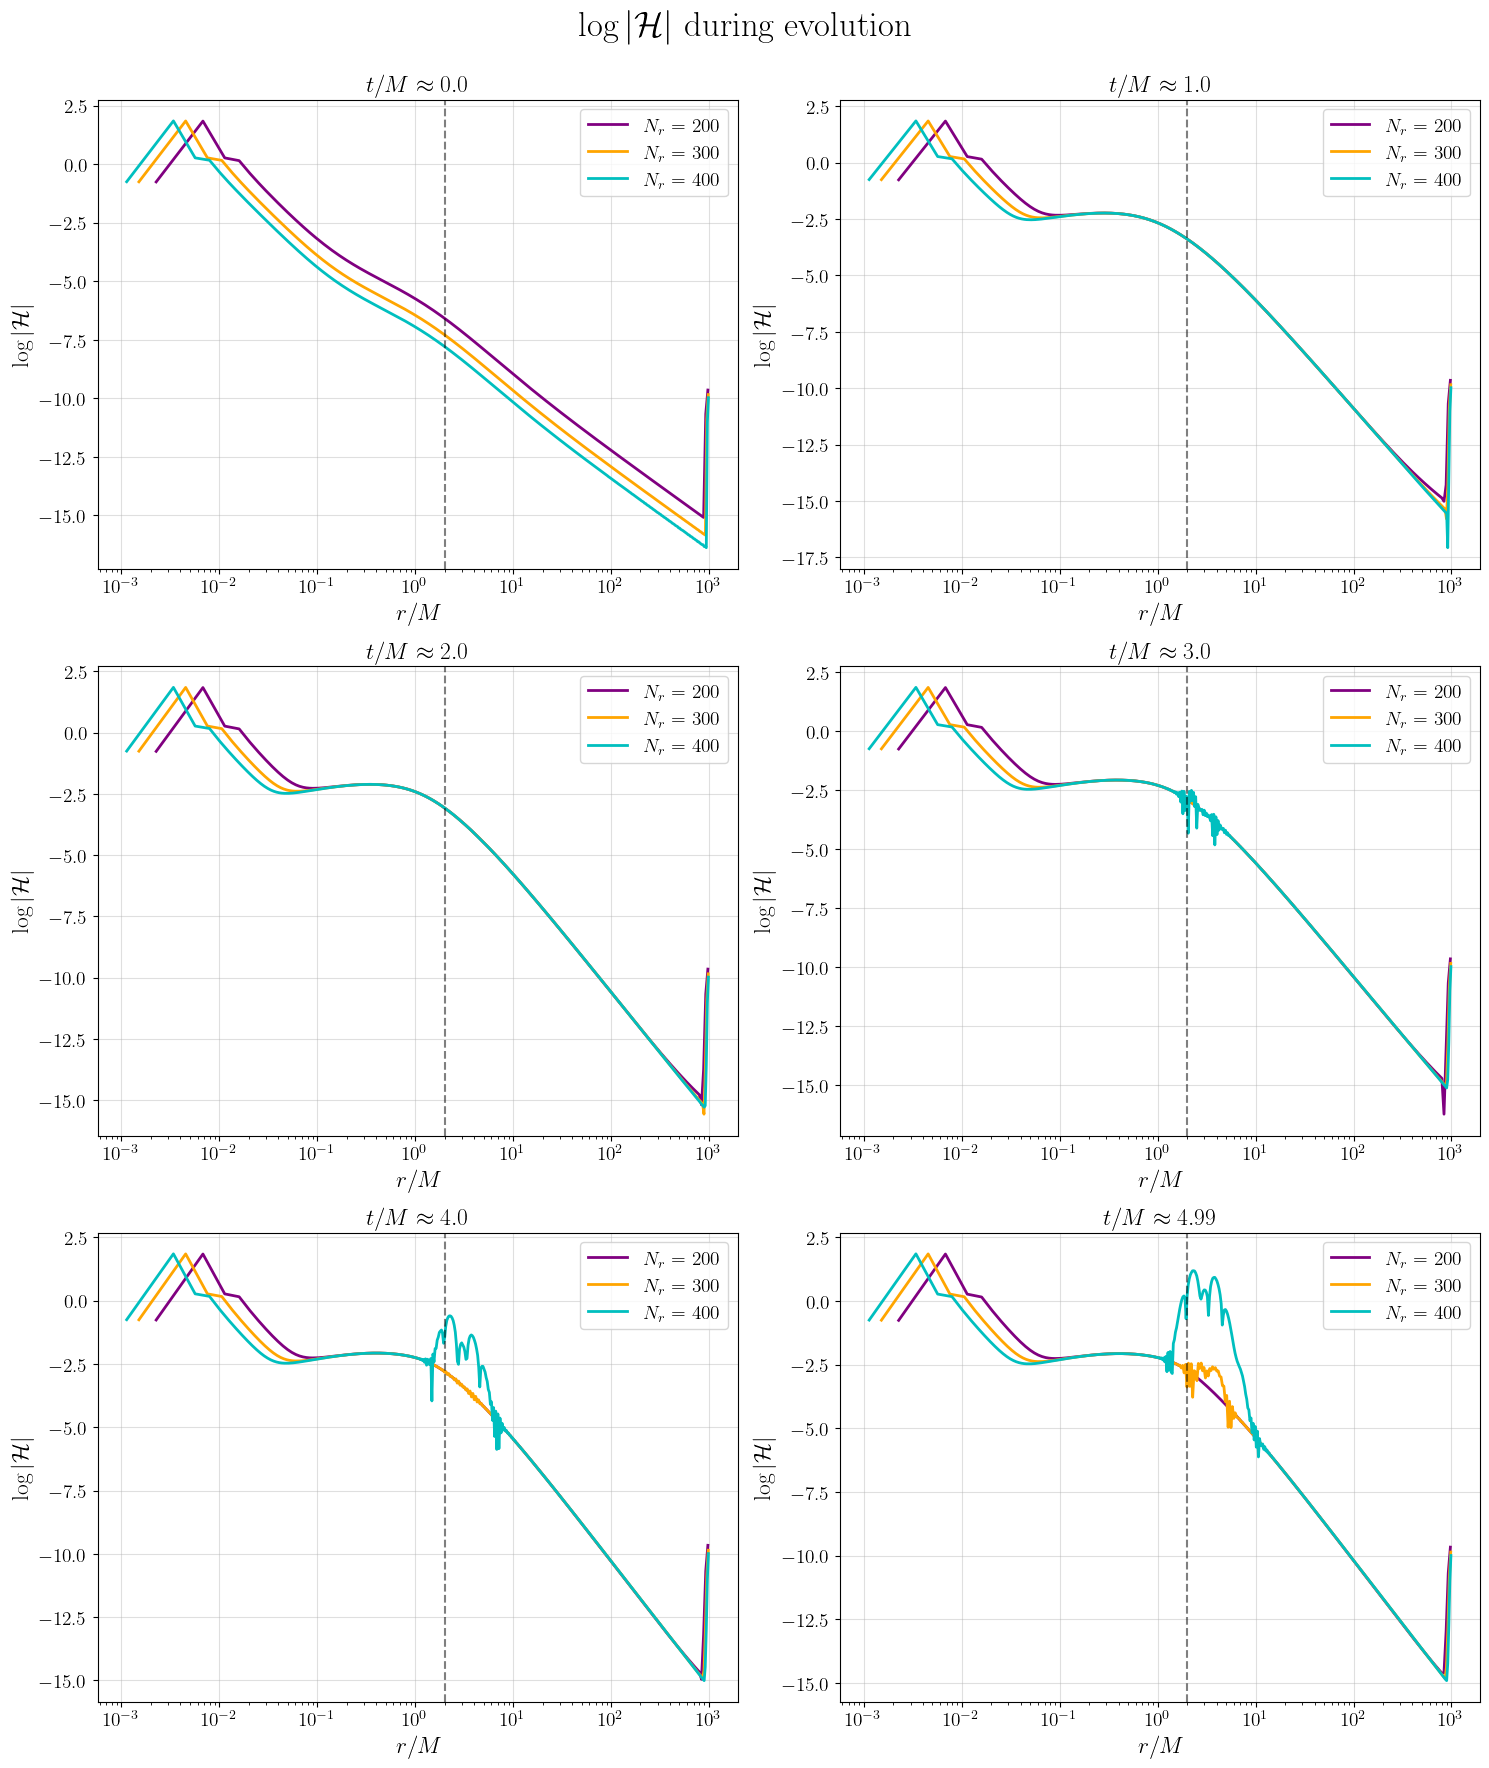

In [ ]:
import simulation_graphs as sg

sg.plot_evolution(tensor_ind=3, out_directory=outdir, r_resolutions=r_resolutions, N_plots=6)

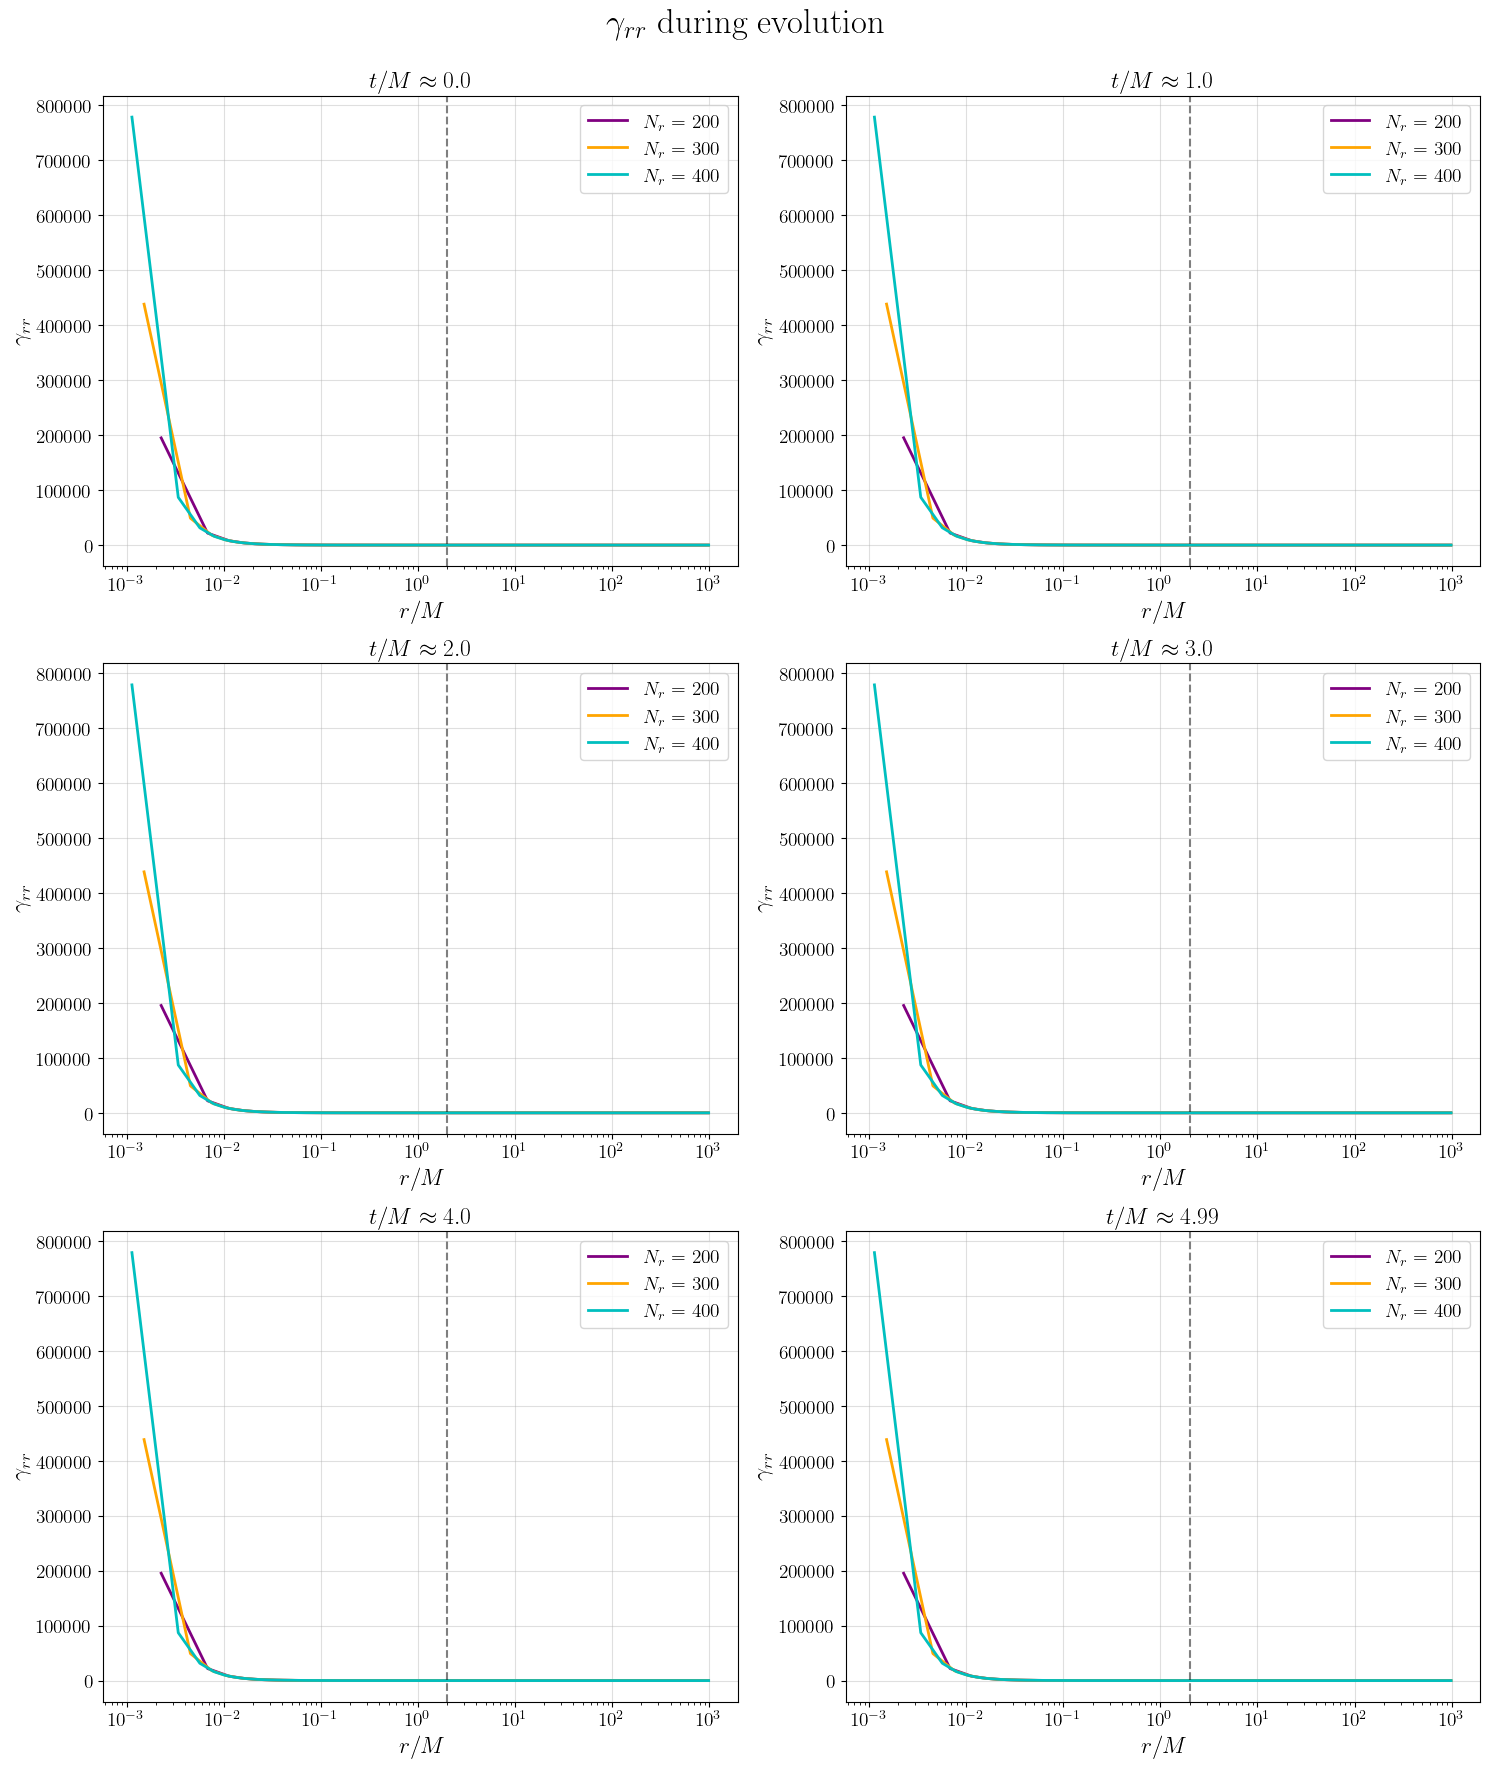

In [24]:
sg.plot_evolution(8, outdir, r_resolutions, 6)

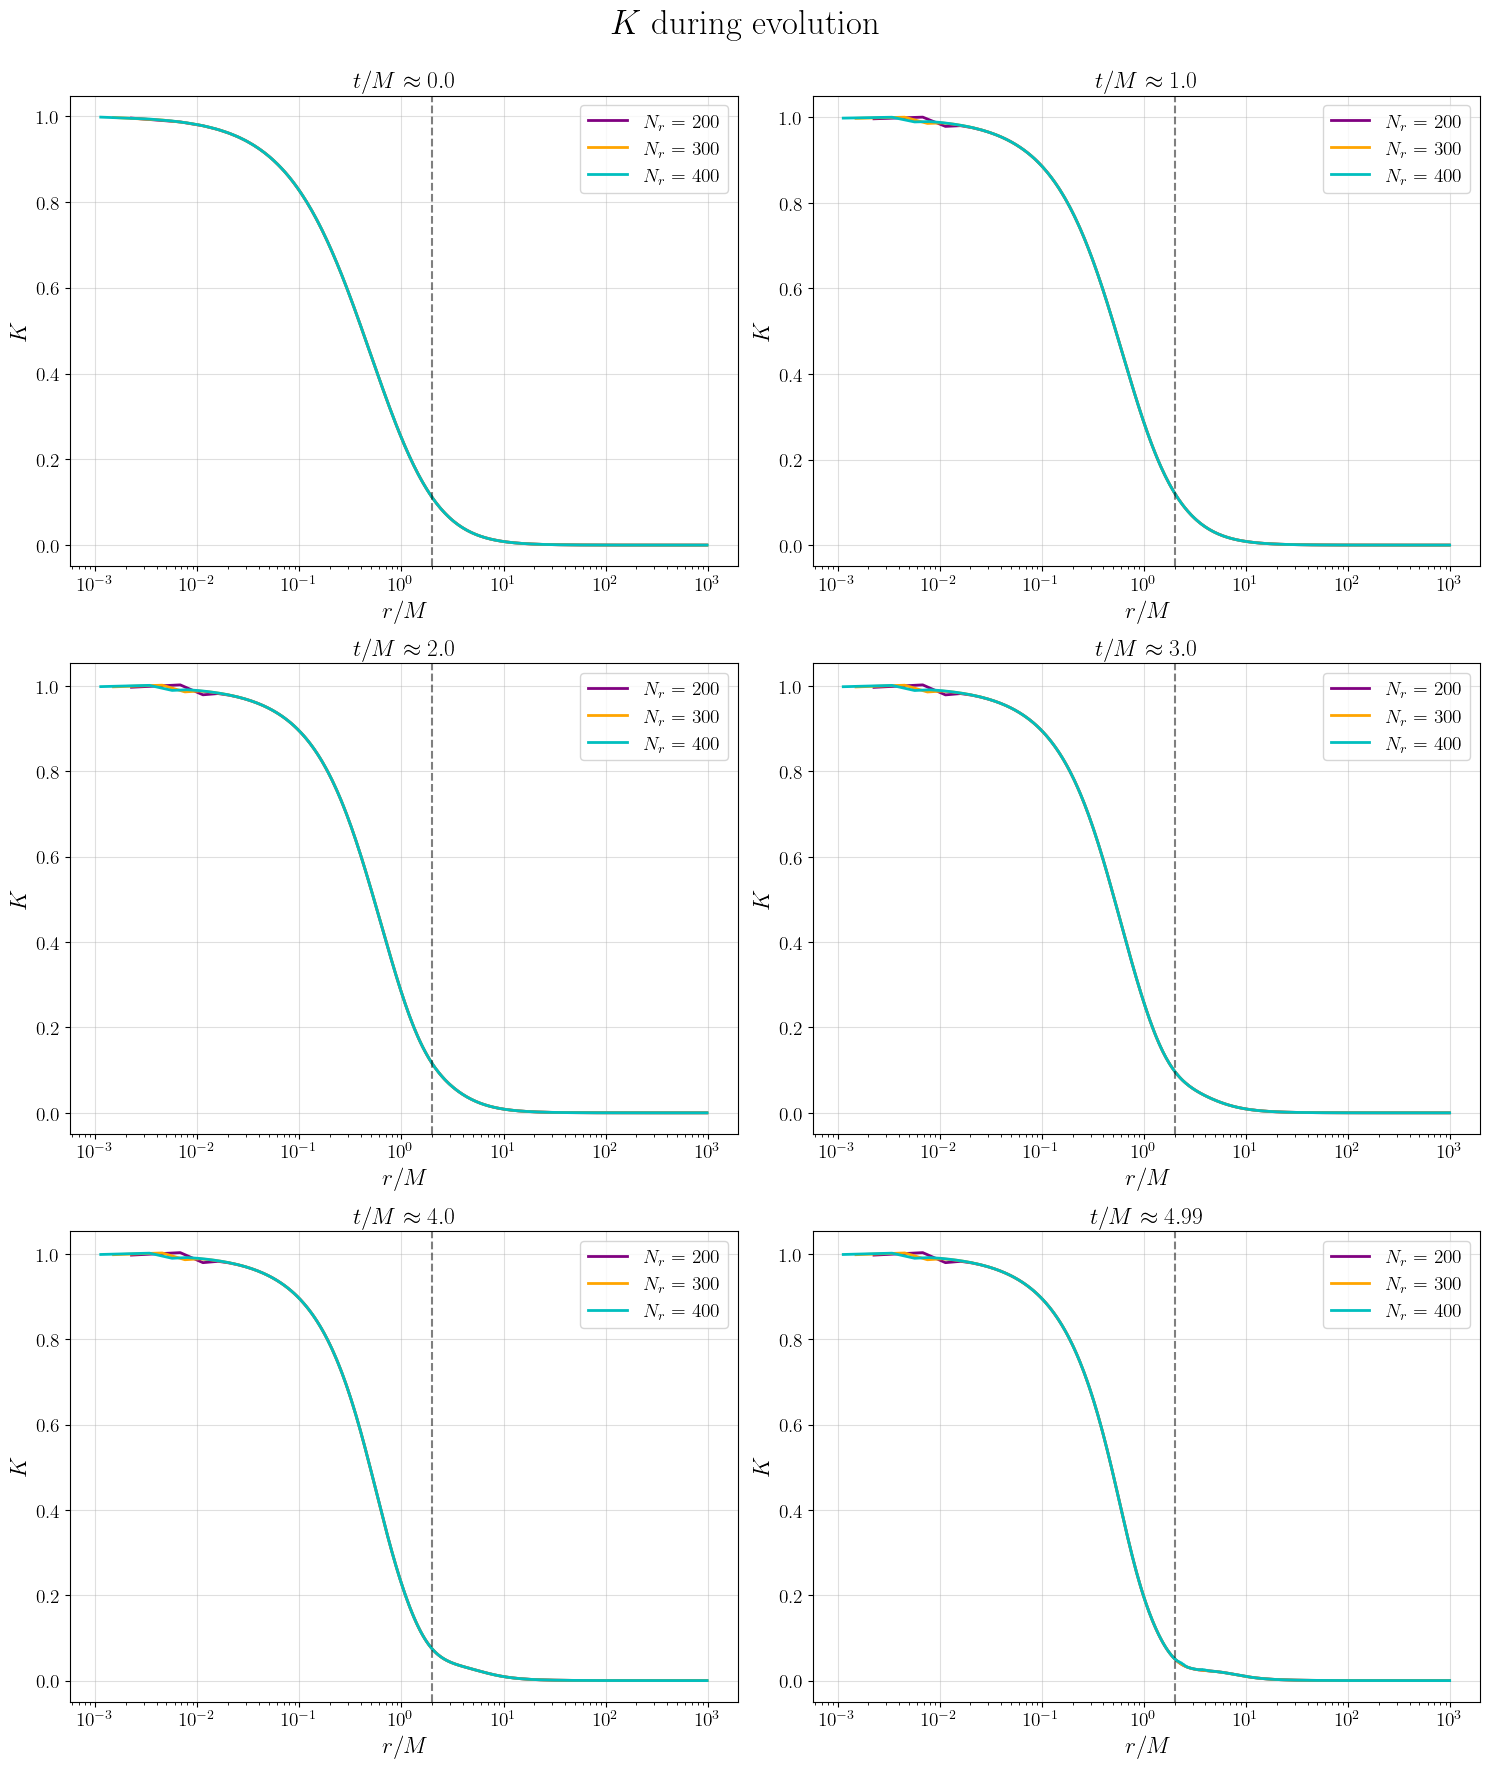

In [25]:
sg.plot_evolution(6, outdir, r_resolutions, 6)

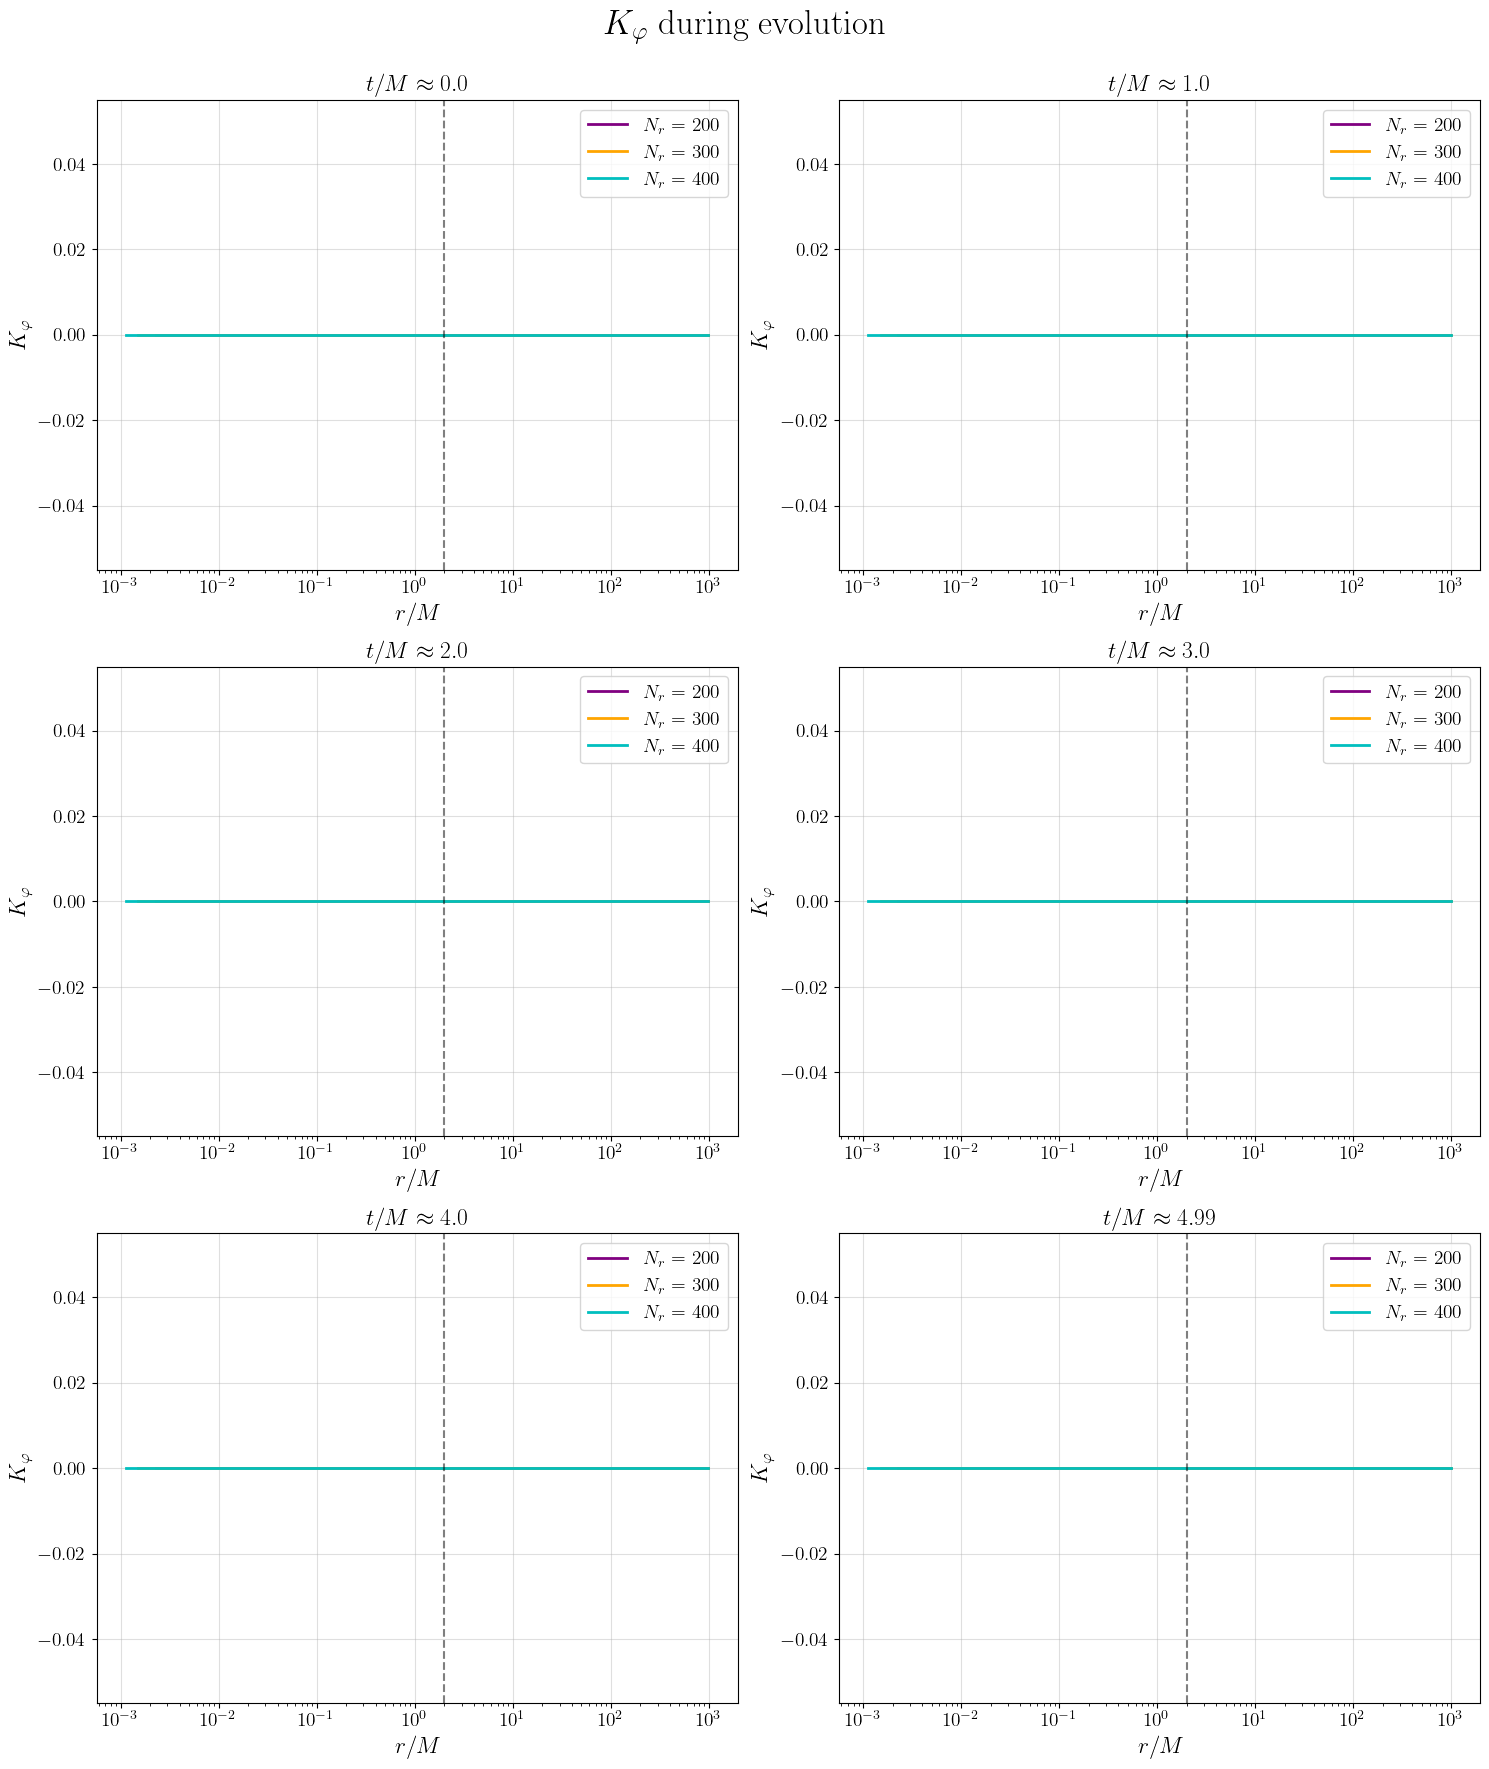

In [ ]:
sg.plot_evolution(7, outdir, r_resolutions, 6)

#### <a id='toc1_3_1_1_'></a>[Interpolate and compare $\mathcal{H}$ multiplied by the truncation error](#toc0_)

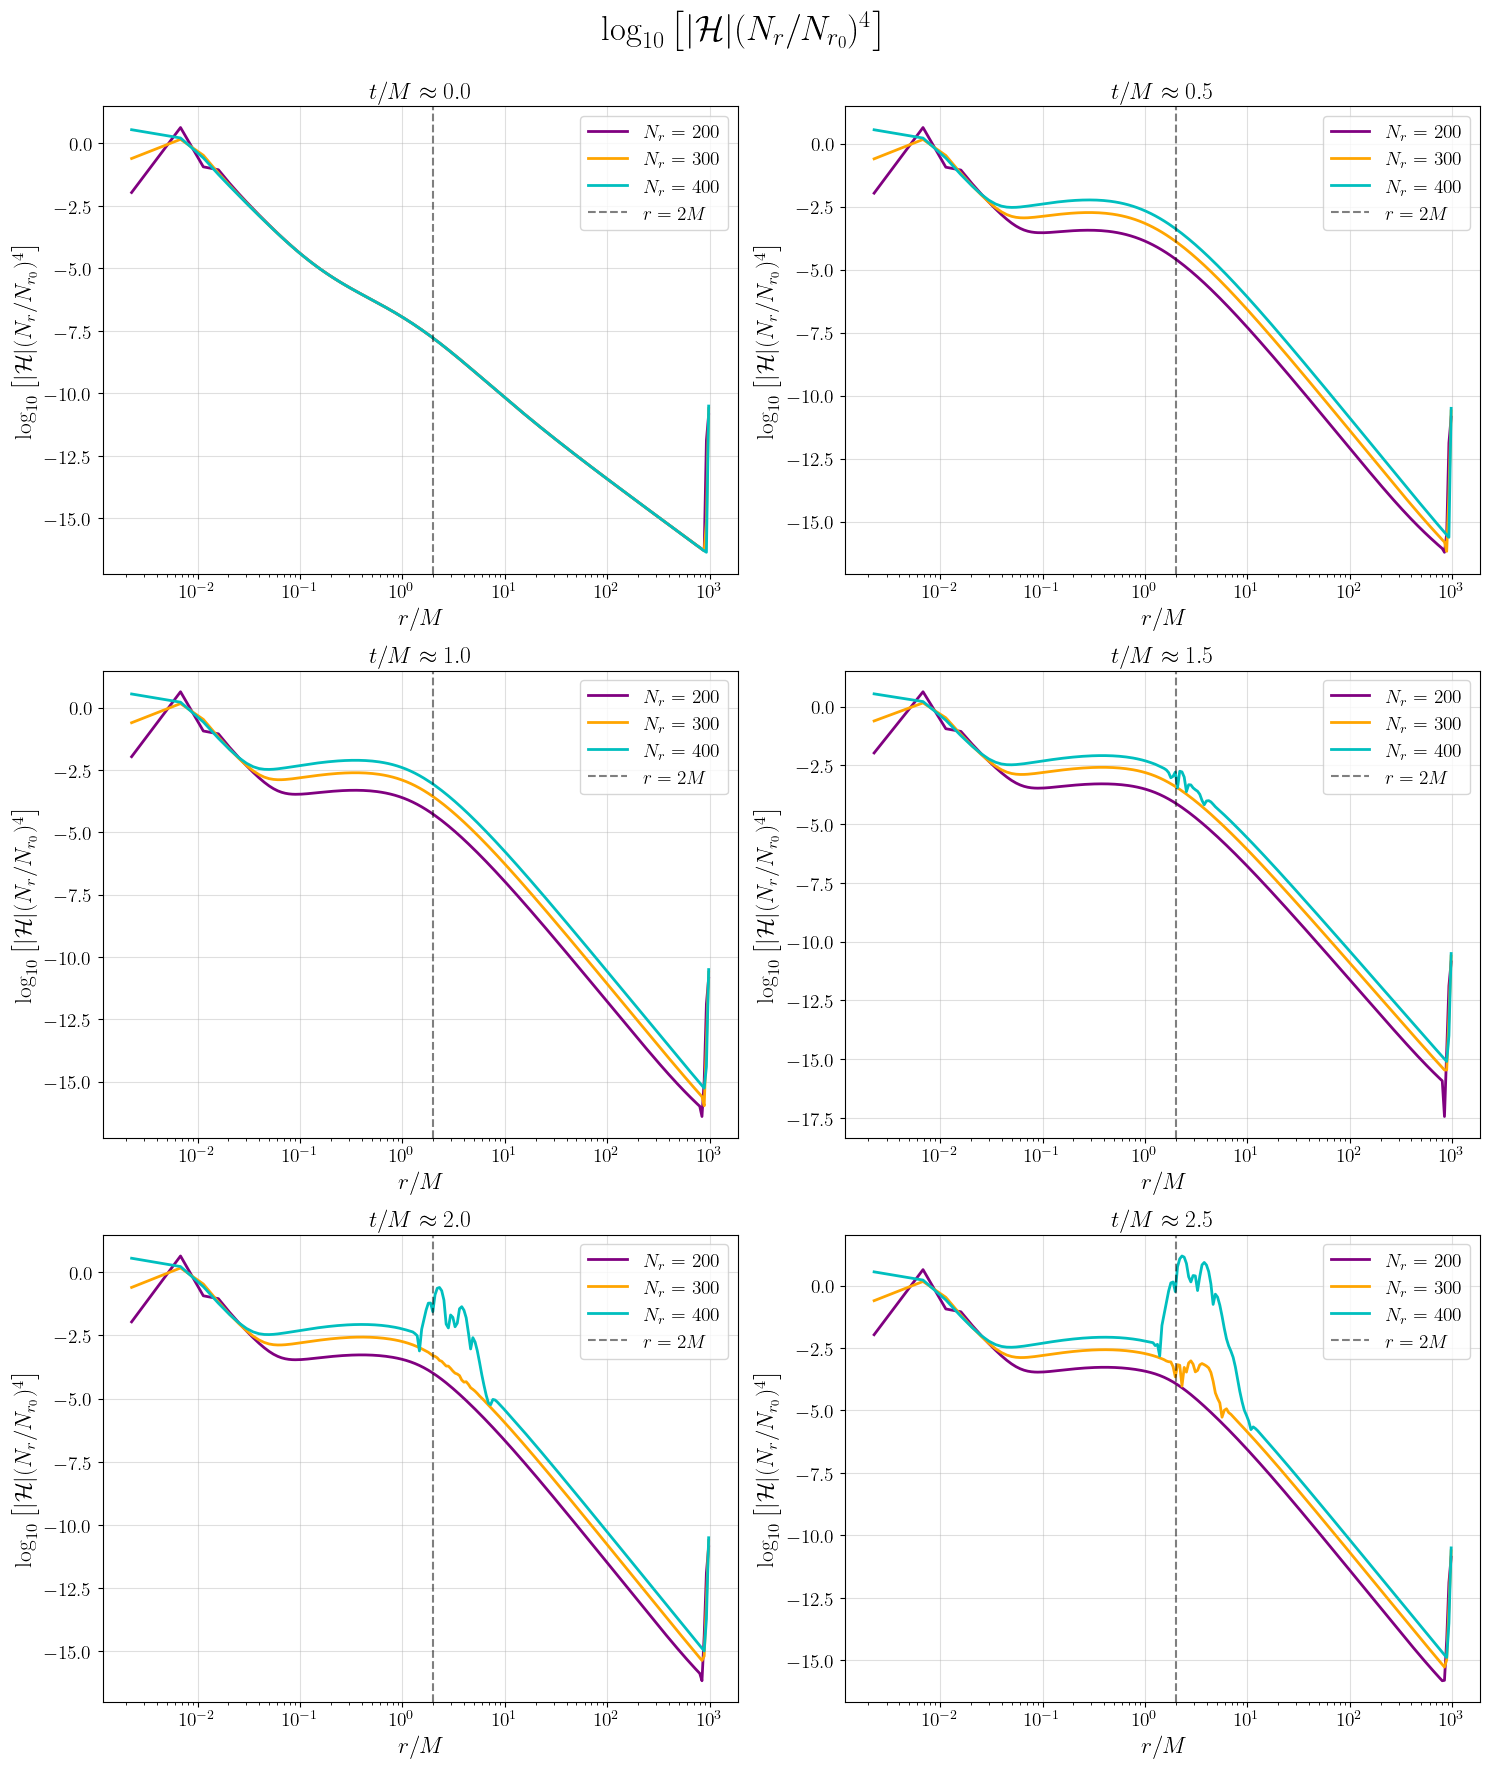

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot as plt
import simulation_graphs as sg
import os

N_plots = 6

resolutions = r_resolutions
data_dir = os.path.join('sGB_ADM_Ccodes', "output")
files = [sg.find_filelist(data_dir, res) for res in resolutions]
for i in range(len(files)):
    files[i] = sg.select_files(files[i], N_plots)
files = list(map(list, zip(*files)))

num_cols = 2  # Number of columns in the grid
num_rows = (N_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

tensor_ind = 3
colors = ['purple', 'orange', 'c']
for i,file_at_step in enumerate(files):
    rs = []	
    hs = []	
    for res, f in zip(resolutions,file_at_step):
        rr, hh = sg.get_data_from_file(3, f)
        hh = hh + np.log10((res/400)**4)
        rs.append(rr)
        hs.append(hh)
    r1, r2, r3 = rs
    H1, H2, H3 = hs
    # Create an interpolation function for H200 on r200 grid
    interp_func1 = interp1d(r2, H2, kind='linear', fill_value="extrapolate")
    interp_func2 = interp1d(r3, H3, kind='linear', fill_value="extrapolate")

    # Interpolate H200 values on the r100 grid
    H2_on_r1 = interp_func1(r1)
    H3_on_r1 = interp_func2(r1)


    axs[i].plot(r1, H1, label=f'$N_r = $ {resolutions[0]}', color=colors[0], linewidth=2)
    axs[i].plot(r1, H2_on_r1, label=f'$N_r = $ {resolutions[1]}', color=colors[1], linewidth=2)
    axs[i].plot(r1, H3_on_r1, label=f'$N_r = $ {resolutions[2]}', color=colors[2], linewidth=2)

    axs[i].set_xscale('log')
    axs[i].axvline(x=2, color='black', linestyle='--', linewidth=1.5, label='$r = 2M$', alpha = 0.5)
    # axs[i].set_ylim(-15, 2.5)
    axs[i].set_xlabel('$r/M$', fontsize=17)
    axs[i].set_ylabel(r'$\log_{10}\big[|\mathcal{H}| (N_{r}/N_{r_0})^4$\big]', fontsize=17)
    dt = sg.find_dt(data_dir,400)
    file_index = sg.get_file_index(file_at_step[0])
    axs[i].set_title(f'$t/M \\approx {round(int(file_index) * dt + dt, 2)}$', fontsize=17)

    # Improved legend placement
    axs[i].legend(fontsize = 14)

    # Add a grid for better readability
    axs[i].grid(alpha=0.4)

    axs[i].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle(r'$\log_{10}\big[|\mathcal{H}| (N_{r}/N_{r_0})^4$\big]', fontsize=25)


plt.tight_layout(rect=[0, 0, 1, 0.98])  
# plt.savefig(os.path.join('figs', '005sGB_convergence_high_res.png'), dpi=450)


#### <a id='toc1_3_1_2_'></a>[Interpolate and subtract $\mathcal{H}$ scaled to the same trunction error for increasing resolutions](#toc0_)

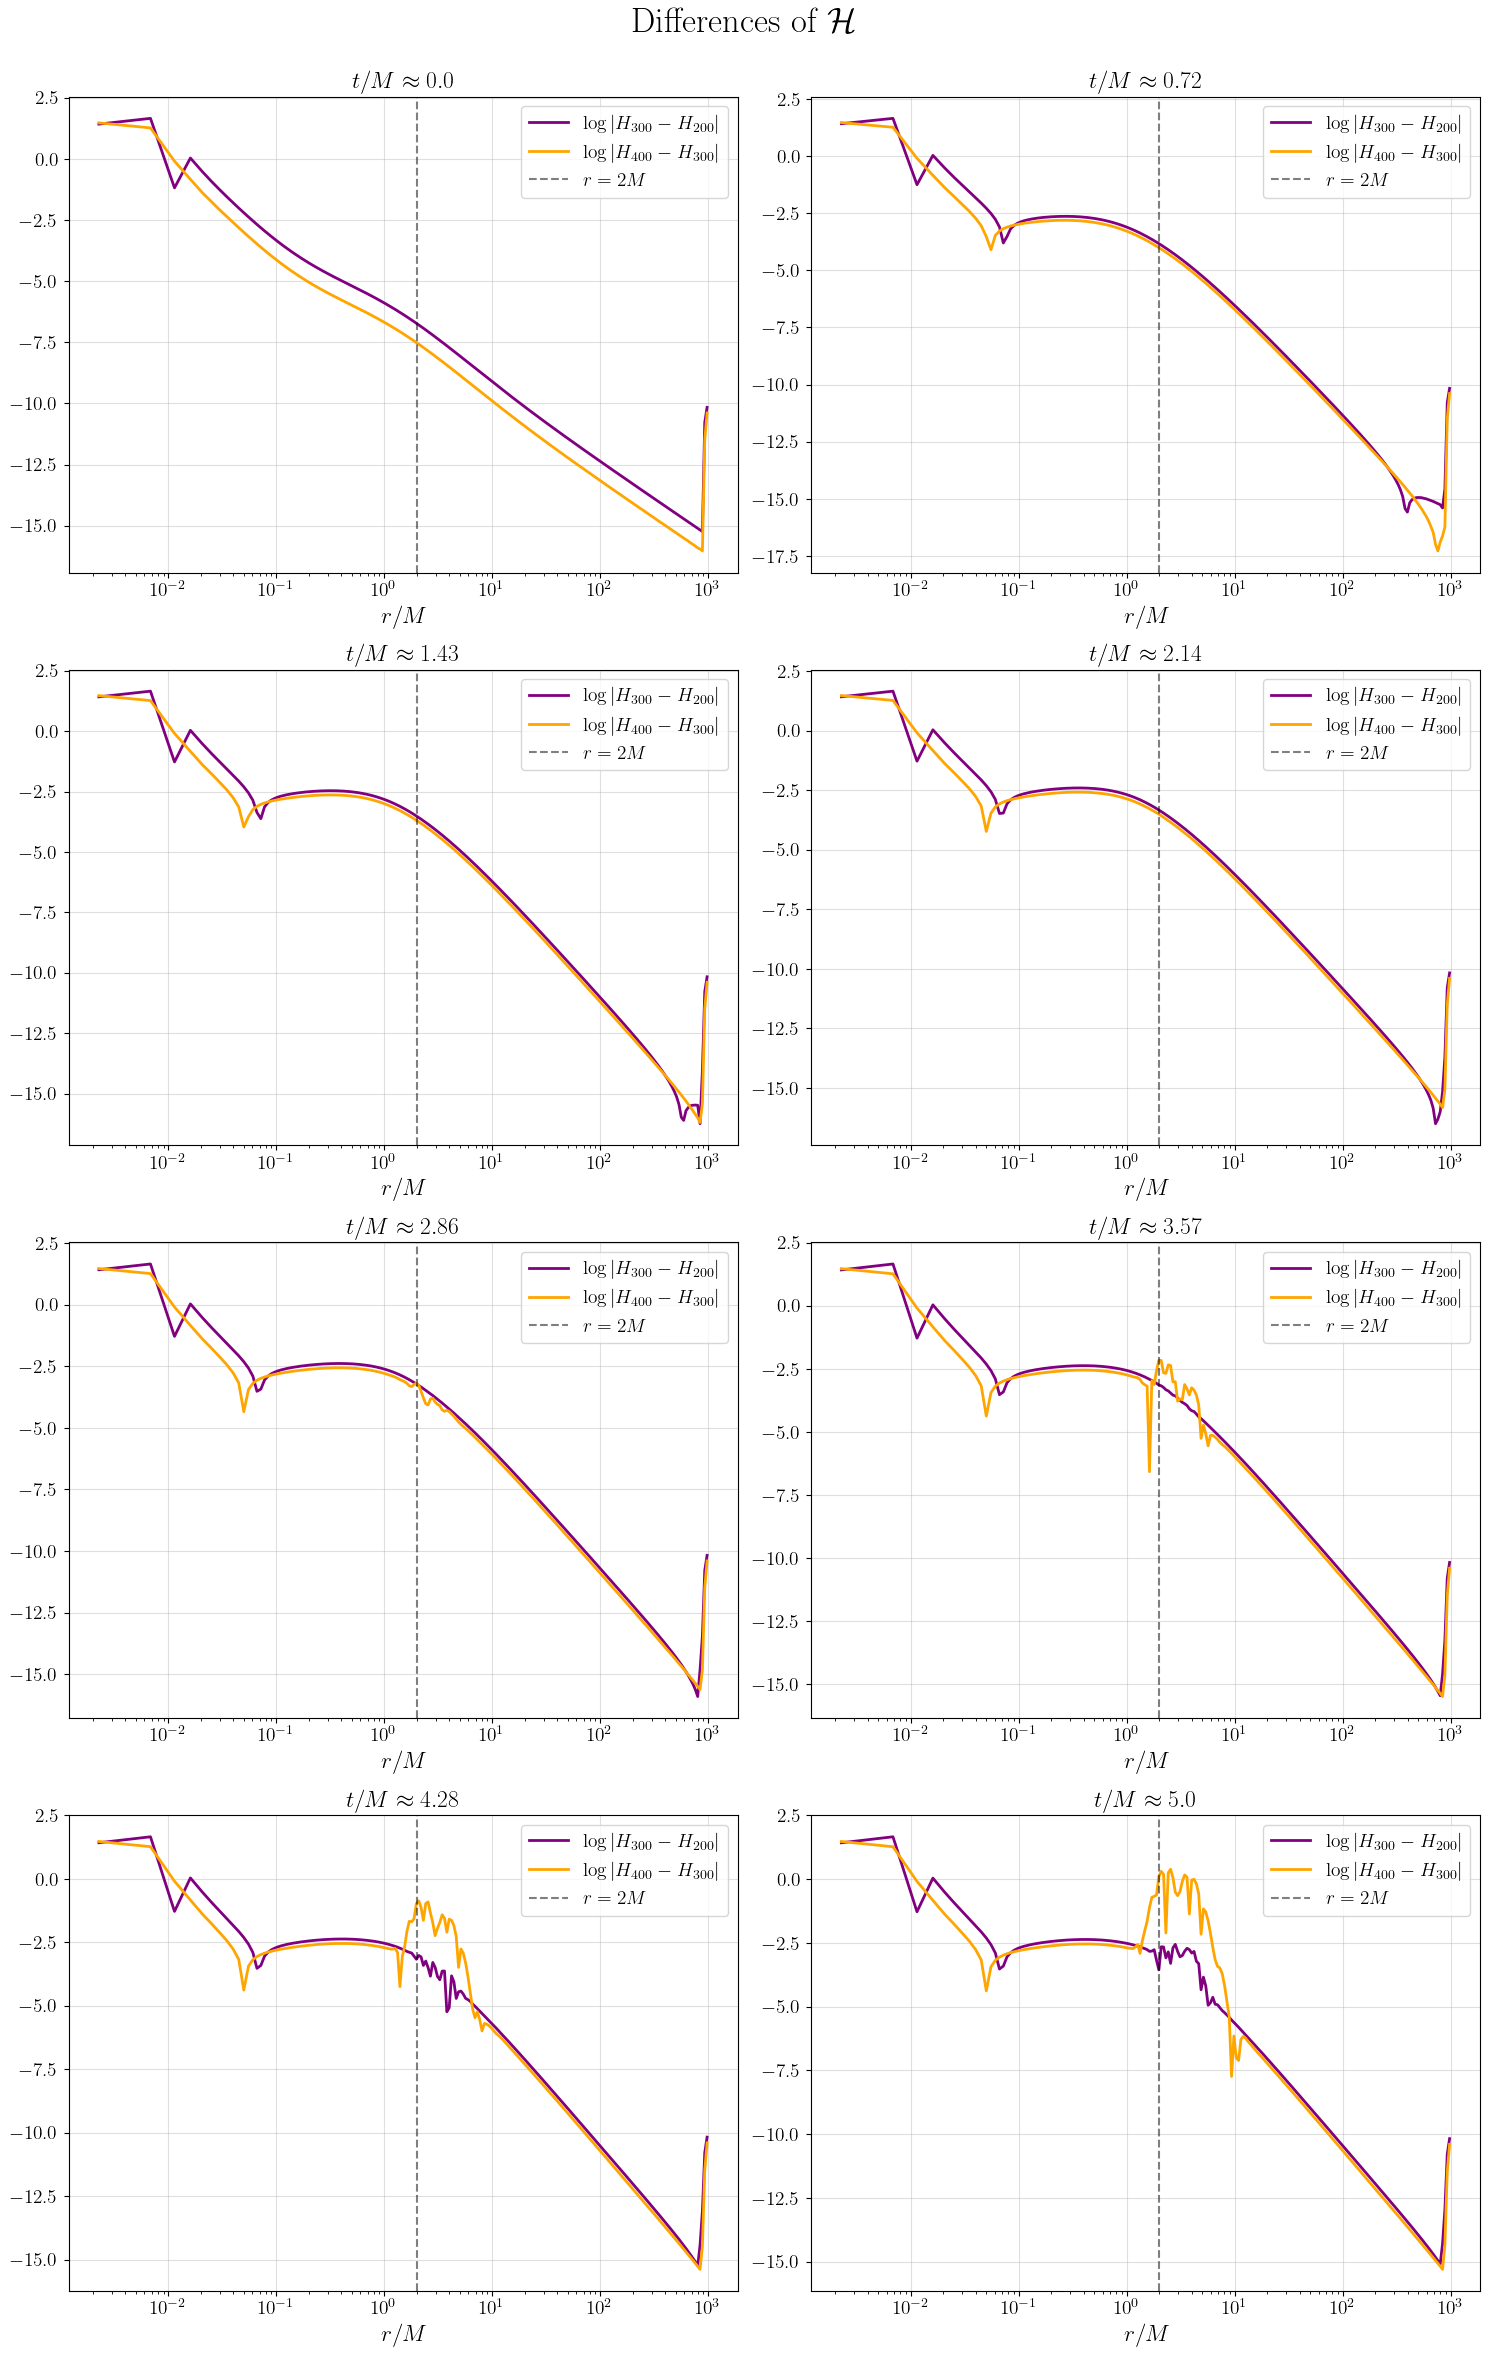

In [ ]:
N_plots = 8

resolutions = r_resolutions
data_dir = os.path.join('sGB_ADM_Ccodes', "output")
files = [sg.find_filelist(data_dir, res) for res in resolutions]
for i in range(len(files)):
    files[i] = sg.select_files(files[i], N_plots)
files = list(map(list, zip(*files)))

num_cols = 2  # Number of columns in the grid
num_rows = (N_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

colors = ['purple', 'orange', 'c']
for i,file_at_step in enumerate(files):
    rs = []	
    hs = []	
    for res, f in zip(resolutions,file_at_step):
        rr, hh = sg.get_data_from_file(4, f)
        rs.append(rr)
        hs.append(hh)
    r1, r2, r3 = rs
    H1, H2, H3 = hs
    # Create an interpolation function for H200 on r200 grid
    interp_func1 = interp1d(r2, H2, kind='linear', fill_value="extrapolate")
    interp_func2 = interp1d(r3, H3, kind='linear', fill_value="extrapolate")

    # Interpolate H200 values on the r100 grid
    H2_on_r1 = interp_func1(r1)
    H3_on_r1 = interp_func2(r1)
    c1 = resolutions[1]/resolutions[0]
    c2 = resolutions[2]/resolutions[1]

    H1_m_H2 = np.log10(np.abs(H1 - H2_on_r1*c1)) #+ np.log10((resolutions[1]/resolutions[0])**4)
    H2_m_H3 = np.log10(np.abs(H2_on_r1 - H3_on_r1*c2)) #+ np.log10((resolutions[2]/resolutions[1])**4)


    axs[i].plot(r1, H1_m_H2, label=r'$\log |H_{300} - H_{200}|$', color=colors[0], linewidth=2)
    axs[i].plot(r1, H2_m_H3, label=r'$\log |H_{400} - H_{300}|$', color=colors[1], linewidth=2)

    axs[i].set_xscale('log')
    axs[i].axvline(x=2, color='black', linestyle='--', linewidth=1.5, label='$r = 2M$', alpha = 0.5)
    # axs[i].set_ylim(-15, 2.5)
    axs[i].set_xlabel('$r/M$', fontsize=17)
    # axs[i].set_ylabel(r'$\log_{10}\big[|\mathcal{H}| (N_{r}/400)^4$\big]', fontsize=17)
    dt = sg.find_dt(data_dir,resolutions[0])
    file_index = sg.get_file_index(file_at_step[0])
    axs[i].set_title(f'$t/M \\approx {round(int(file_index) * dt + dt, 2)}$', fontsize=17)

    # Improved legend placement
    axs[i].legend(fontsize = 14)

    # Add a grid for better readability
    axs[i].grid(alpha=0.4)

    axs[i].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle(r'Differences of $\mathcal{H}$', fontsize=25)


plt.tight_layout(rect=[0, 0, 1, 0.98])  
# plt.savefig(os.path.join('figs', '005sGB_convergence_high_res.png'), dpi=450)

